# COVID Tweets - Database Assignment
#### April 16th, 2021 

##### By Hudson Ukass and Justin Przybliski

Notes: 

In [197]:
import sklearn as sk
import os
import pandas as pd
import numpy as np
from pandas import DataFrame
import altair as alt
import spacy as sp
import matplotlib.pyplot as plt
os.chdir('/Users/hudso/OneDrive/Documents/COMP 4522/COVIDTweets-Machine-Learning')
sp.load('en_core_web_sm')

#Covid Tweets dataset
#https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets
covidTweets = pd.read_csv("vaccination_all_tweets.csv")
#Covid Cases Data
#https://www.kaggle.com/gauravduttakiit/covid-19
covidCases = pd.read_csv("worldwide-aggregate.csv")

#Datetime conversions and hour/min/sec rounding 
#for covidTweets and CovidCases df's.
covidTweets["user_created"] = pd.to_datetime(covidTweets["user_created"], errors='coerce').dt.date
covidTweets["date"] = pd.to_datetime(covidTweets["date"], errors='coerce').dt.date
covidCases["Date"] = pd.to_datetime(covidCases["Date"], errors='coerce').dt.date
#covidTweets = covidTweets.assign(date=covidTweets.date.dt.round('D'))
cc = covidCases
cc = cc.drop(columns='Increase rate')
cc['Confirmed'] -= cc['Confirmed'].shift(1).fillna(0)
cc['Recovered'] -= cc['Recovered'].shift(1).fillna(0)
cc['Deaths'] -= cc['Deaths'].shift(1).fillna(0)


#Drop null and irellevant columns about user profiles 
tweetCase = covidTweets.drop(columns=['user_location', 'user_description', 'user_created', 'hashtags', 'source'])

#Merge the covidTweets and covidCases on their dates.
tweetCase = pd.merge(left=tweetCase, right=cc, how='left', left_on='date', 
                  right_on='Date')
tweetCase = tweetCase.drop(columns='Date')
tweetCase = tweetCase.sort_values(by='date', ascending=True)

#Tweet count and covid case stats by day
tweetsDay = tweetCase.groupby('date').count()
tweetsDay = tweetsDay.loc[:,'id']
tweetsDay = tweetsDay.rename('tweet_count')
tweetsDay = pd.merge(left=tweetsDay, right=cc, how='left', left_on='date', 
                  right_on='Date')
tweetsDay = tweetsDay.dropna(axis=0)
tweetsDay = tweetsDay.sort_values(by='Date', ascending=True)
#tweetsDay['tweet_count'] = tweetsDay['tweet_count'].cumsum()

tweetsDay = tweetsDay.drop([0,1,2,3])
tweetsDay = tweetsDay.reset_index()
tweetsDay = tweetsDay.drop(columns='index')

tweetsDay.head()

,tweet_count,Date,Confirmed,Recovered,Deaths
0,144,2020-12-16,733726.0,362220.0,13717.0
1,139,2020-12-17,739582.0,375409.0,13415.0
2,112,2020-12-18,720462.0,317728.0,12765.0
3,110,2020-12-19,611253.0,351586.0,10768.0
4,68,2020-12-20,533473.0,276829.0,7911.0


# Machine Learning - Linear Regression
With help of Kaggle Tutorial


In [79]:
#Define the parameters of X and y here. 
covidN = covidTweets.dropna()

#Prediction target
y = covidN.retweets

#Prediction criteria 
covid_features = ['user_friends', 'user_followers', 'user_favourites', 
                    'favorites']
X = covidN[covid_features]
X.head()

,user_friends,user_followers,user_favourites,favorites
0,1692,405,3247,0
2,88,10,155,0
6,5001,2731,69344,4
9,2368,671,20469,0
10,78,1302,339,0


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
covid_model = DecisionTreeRegressor()
covid_model.fit(X, y)

predicted_retweets = covid_model.predict(X)
mean_absolute_error(y, predicted_retweets)

#In-Sample Scoring
print("Making retweet predictions for the following 5 Tweets:")
print(X.head())
print("The retweet predictions are")
print(covid_model.predict(X.head()))

Making retweet predictions for the following 5 Tweets:
    user_friends  user_followers  user_favourites  favorites
0           1692             405             3247          0
2             88              10              155          0
6           5001            2731            69344          4
9           2368             671            20469          0
10            78            1302              339          0
The retweet predictions are
[0. 0. 0. 0. 0.]


In [81]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

#Out-of-Sample Scoring 
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

covid_model = DecisionTreeRegressor()
covid_model.fit(train_X, train_y)

val_predictions = covid_model.predict(val_X)
#Print the degree of error for out-of-sample
print("General Degree of Error: ", mean_absolute_error(val_y, val_predictions))

def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)
# compare MAE with differing values of max_leaf_nodes
for max_leaf_nodes in [5, 50, 500, 5000, 50000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

General Degree of Error:  2.776160421688537
Max leaf nodes: 5  		 Mean Absolute Error:  4
Max leaf nodes: 50  		 Mean Absolute Error:  2
Max leaf nodes: 500  		 Mean Absolute Error:  2
Max leaf nodes: 5000  		 Mean Absolute Error:  2
Max leaf nodes: 50000  		 Mean Absolute Error:  2


### Optimal number of leaves is: 50

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
melb_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, melb_preds))

2.2545510049952404


In [206]:
X = tweetsDay.loc[:,['Confirmed','Recovered','Deaths']].values
y = tweetsDay.tweet_count
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

regressor = RandomForestRegressor(n_estimators=50, random_state=1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 388.9291666666666
Mean Squared Error: 243125.18464999998
Root Mean Squared Error: 493.0772603253977


In [84]:
covidN.retweets.describe()

count    32857.000000
mean         3.850321
std         57.527579
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       7695.000000
Name: retweets, dtype: float64

In [204]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Choose target and features

y = tweetsDay.tweet_count
tweetsDay_features = ['Confirmed','Recovered','Deaths']
X = tweetsDay[tweetsDay_features]


# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
melb_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, melb_preds))

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Specify Model
tweet_model = DecisionTreeRegressor(random_state=1)
# Fit Model
tweet_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = tweet_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

# Using best value for max_leaf_nodes
tweet_model = DecisionTreeRegressor(max_leaf_nodes=247, random_state=1)
tweet_model.fit(train_X, train_y)
val_predictions = tweet_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))

print(f'Model Accuracy: {tweet_model.score(X, y)}')

tweet_model.fit(X,y)
importance = tweet_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

424.696
Validation MAE when not specifying max_leaf_nodes: 574
Validation MAE for best value of max_leaf_nodes: 522
Model Accuracy: 0.4083301712308124
Feature: 0, Score: 0.09722
Feature: 1, Score: 0.39345
Feature: 2, Score: 0.50934


370436.2568418048


<AxesSubplot:title={'center':'What Covid Factors Influence the Amount of Tweets by Day the Most?\nFrom 12/12/2020 - 04/12/2021'}, ylabel='None'>

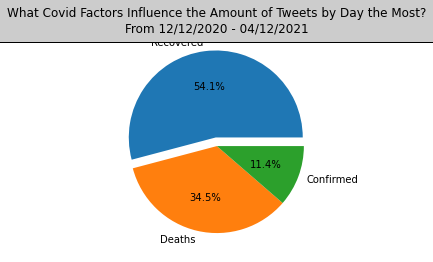

In [205]:
target = 'tweet_count'
features = ['Confirmed','Recovered','Deaths']
train2 = tweetsDay.sample(frac=0.8, random_state=1)
test2 = tweetsDay.loc[~tweetsDay.index.isin(train2.index)]

model = RandomForestRegressor(n_estimators=247, min_samples_leaf=8, random_state=1)

# Fit the model to the data.
model.fit(train2[features], train2[target])
# Make predictions.
predictions_rf = model.predict(test2[features])
# Compute the error.
print(mean_squared_error(predictions_rf, test2[target]))
import matplotlib.ticker as mtick

#plt.ylabel("Impact on Tweet Amount", fontsize = 14)
#plt.xlabel("Global COVID Factors", fontsize = 14)
#plt.ylabel

feat_importances = pd.Series(model.feature_importances_, index=features)

tweetPlot = feat_importances.nlargest().plot(kind='pie', normalize=False, 
                                             explode=(0.1,0,0), 
                                             autopct='%1.1f%%')

#tweetPlot.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

tweetPlot.axes.get_xaxis().set_visible(False)
tweetPlot.axes.get_yaxis().set_visible(False)
plt.title("What Covid Factors Influence the Amount of Tweets by Day the Most?\n" + 
          "From 12/12/2020 - 04/12/2021", bbox={'facecolor':'0.8', 'pad':8})

tweetPlot

In [87]:
features = pd.get_dummies(tweetsDay)
labels = tweetsDay['tweet_count']
features = tweetsDay.drop('tweet_count', axis=1)
feature_list = list(features.columns)
labels = np.array(labels)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels,         
                                                                            test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (91, 5)
Training Labels Shape: (91,)
Testing Features Shape: (31, 5)
Testing Labels Shape: (31,)


424.1967836257309
Mean Absolute Error: 424.1967836257309
Mean Squared Error: 366791.96302421263
Root Mean Squared Error: 605.6335220446542


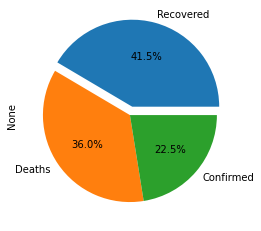

In [257]:
# Choose target and features
y = tweetsDay.tweet_count
features = ['Recovered', 'Confirmed', 'Deaths']
X = tweetsDay[features]

from sklearn.model_selection import train_test_split

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state = 1)
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
val_X = sc.transform(val_X)

#Optimal number of estimators was 28.
forest_model = RandomForestRegressor(n_estimators=570, random_state=1)
forest_model.fit(train_X, train_y)
y_pred = forest_model.predict(val_X)
print(mean_absolute_error(val_y, y_pred))

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(val_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(val_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(val_y, y_pred)))
feat_importances = pd.Series(forest_model.feature_importances_, index=features)
tweetPlot = feat_importances.nlargest().plot(kind='pie', normalize=False, 
                                             explode=(0.1,0,0), 
                                             autopct='%1.1f%%')

In [111]:
tweetsDay.shape

#Prep data 
#Determine target + features
#H

(122, 6)

In [104]:
tweetCase.head()

,id,user_name,user_followers,user_friends,user_favourites,user_verified,date,text,retweets,favorites,is_retweet,Confirmed,Recovered,Deaths,Increase rate
294,1337884374927368201,Nacindex,331,431,1132,False,2020-12-12,https://t.co/Z3j0NbDUbq\nUS agency authorizes ...,1,0,False,71903752.0,46933277.0,1609529.0,0.890777
34,1337742528108519424,Rajat Kotra,754,917,220,False,2020-12-12,Vaccine!! Anyone?? #covid #Pfizervaccine #Pfiz...,0,0,False,71903752.0,46933277.0,1609529.0,0.890777
35,1337739607857917954,Shahjhan Malik | #WearAMask,41708,2868,47862,False,2020-12-12,An immigrant Muslim couple find the COVID-19 V...,2,37,False,71903752.0,46933277.0,1609529.0,0.890777
36,1337735595704115200,John Berry,2,0,0,False,2020-12-12,The #FDA finally issues #EUA now comes the pro...,0,0,False,71903752.0,46933277.0,1609529.0,0.890777
37,1337734069816348673,Farooq Anees,293,319,165,False,2020-12-12,"Ladies and Gentlemen, now we have #CovidVaccin...",0,0,False,71903752.0,46933277.0,1609529.0,0.890777


In [213]:
#TODO
import seaborn as sns

#Separate data to daily rather than cumulative 
tweetsDay.head()
 
#Classification(?)


,tweet_count,Date,Confirmed,Recovered,Deaths
0,144,2020-12-16,733726.0,362220.0,13717.0
1,139,2020-12-17,739582.0,375409.0,13415.0
2,112,2020-12-18,720462.0,317728.0,12765.0
3,110,2020-12-19,611253.0,351586.0,10768.0
4,68,2020-12-20,533473.0,276829.0,7911.0


<AxesSubplot:xlabel='Deaths', ylabel='tweet_count'>

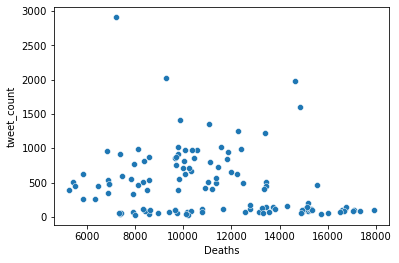

In [314]:
#Plot for outliers 
sns.scatterplot(x=tweetsDay['Deaths'], y=tweetsDay['tweet_count'])

In [362]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
#Plot a cluster, compare to old faithful (4 clusters, what do they look like?)
# - Scale for clusters
td = tweetsDay[['tweet_count','Confirmed','Recovered','Deaths']]

#ntd = preprocessing.normalize(td)
#ntd = pd.DataFrame(ntd, columns=['tweet_count','Confirmed','Recovered','Deaths'])
ntd.head()
#td.tweet_count.idxmax()
#td = td.drop(75)
#td.sort_values(by='tweet_count', ascending=False).head(30)

,tweet_count,Confirmed,Recovered,Deaths
0,0.000176,0.896559,0.442606,0.016761
1,0.000168,0.891585,0.452565,0.016172
2,0.000142,0.914855,0.403457,0.016209
3,0.000156,0.866734,0.498536,0.015269
4,0.000113,0.887533,0.460557,0.013161


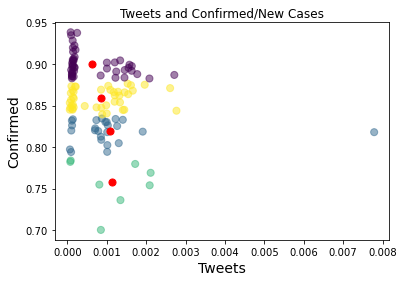

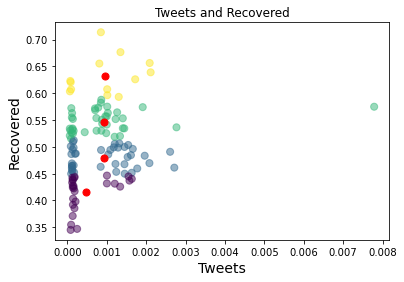

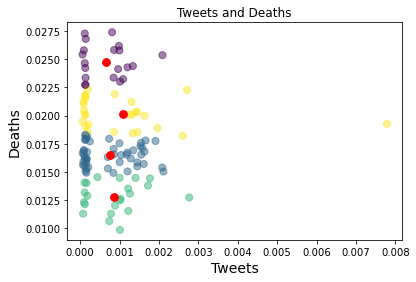

In [363]:
kmeans = KMeans(n_clusters=4).fit(ntd[['tweet_count','Confirmed']])
centroids = kmeans.cluster_centers_
#print(centroids)
plt.scatter(ntd['tweet_count'], ntd['Confirmed'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.ylabel("Confirmed", fontsize = 14)
plt.xlabel("Tweets", fontsize = 14)
plt.title("Tweets and Confirmed/New Cases")
plt.show()

kmeans = KMeans(n_clusters=4).fit(ntd[['tweet_count','Recovered']])
centroids = kmeans.cluster_centers_
#print(centroids)
plt.scatter(ntd['tweet_count'], ntd['Recovered'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.ylabel("Recovered", fontsize = 14)
plt.xlabel("Tweets", fontsize = 14)
plt.title("Tweets and Recovered")
plt.show()

kmeans = KMeans(n_clusters=4).fit(ntd[['tweet_count','Deaths']])
centroids = kmeans.cluster_centers_
#print(centroids)
plt.scatter(ntd['tweet_count'], ntd['Deaths'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=60)
plt.ylabel("Deaths", fontsize = 14)
plt.xlabel("Tweets", fontsize = 14)
plt.title("Tweets and Deaths")
plt.show()

In [317]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
td = tweetsDay
print(td.shape)
td.head()

(119, 7)


,tweet_count,Date,Confirmed,Recovered,Deaths,bins,tweet_bins
0,144,2020-12-16,733726.0,362220.0,13717.0,Small,Small
1,139,2020-12-17,739582.0,375409.0,13415.0,Small,Small
2,112,2020-12-18,720462.0,317728.0,12765.0,Small,Small
3,110,2020-12-19,611253.0,351586.0,10768.0,Small,Small
4,68,2020-12-20,533473.0,276829.0,7911.0,Small,Small


<AxesSubplot:ylabel='tweet_vol'>

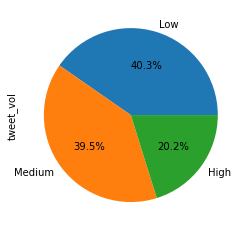

In [322]:
tweet_vol = ['Low','Medium','High']
td['tweet_vol'] = pd.qcut(td['tweet_count'], q=[0,0.4,0.8,1], labels=tweet_vol)
td.tail()
td.tweet_vol.value_counts().plot(kind='pie',autopct='%1.1f%%')

In [324]:
td = td.drop(columns=['bins','tweet_bins'])
td.head()

,tweet_count,Date,Confirmed,Recovered,Deaths,tweet_vol
0,144,2020-12-16,733726.0,362220.0,13717.0,Low
1,139,2020-12-17,739582.0,375409.0,13415.0,Low
2,112,2020-12-18,720462.0,317728.0,12765.0,Low
3,110,2020-12-19,611253.0,351586.0,10768.0,Low
4,68,2020-12-20,533473.0,276829.0,7911.0,Low


In [354]:
feature_cols = ['Confirmed','Recovered','Deaths']
X = td[feature_cols]
y = td.tweet_vol
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4166666666666667


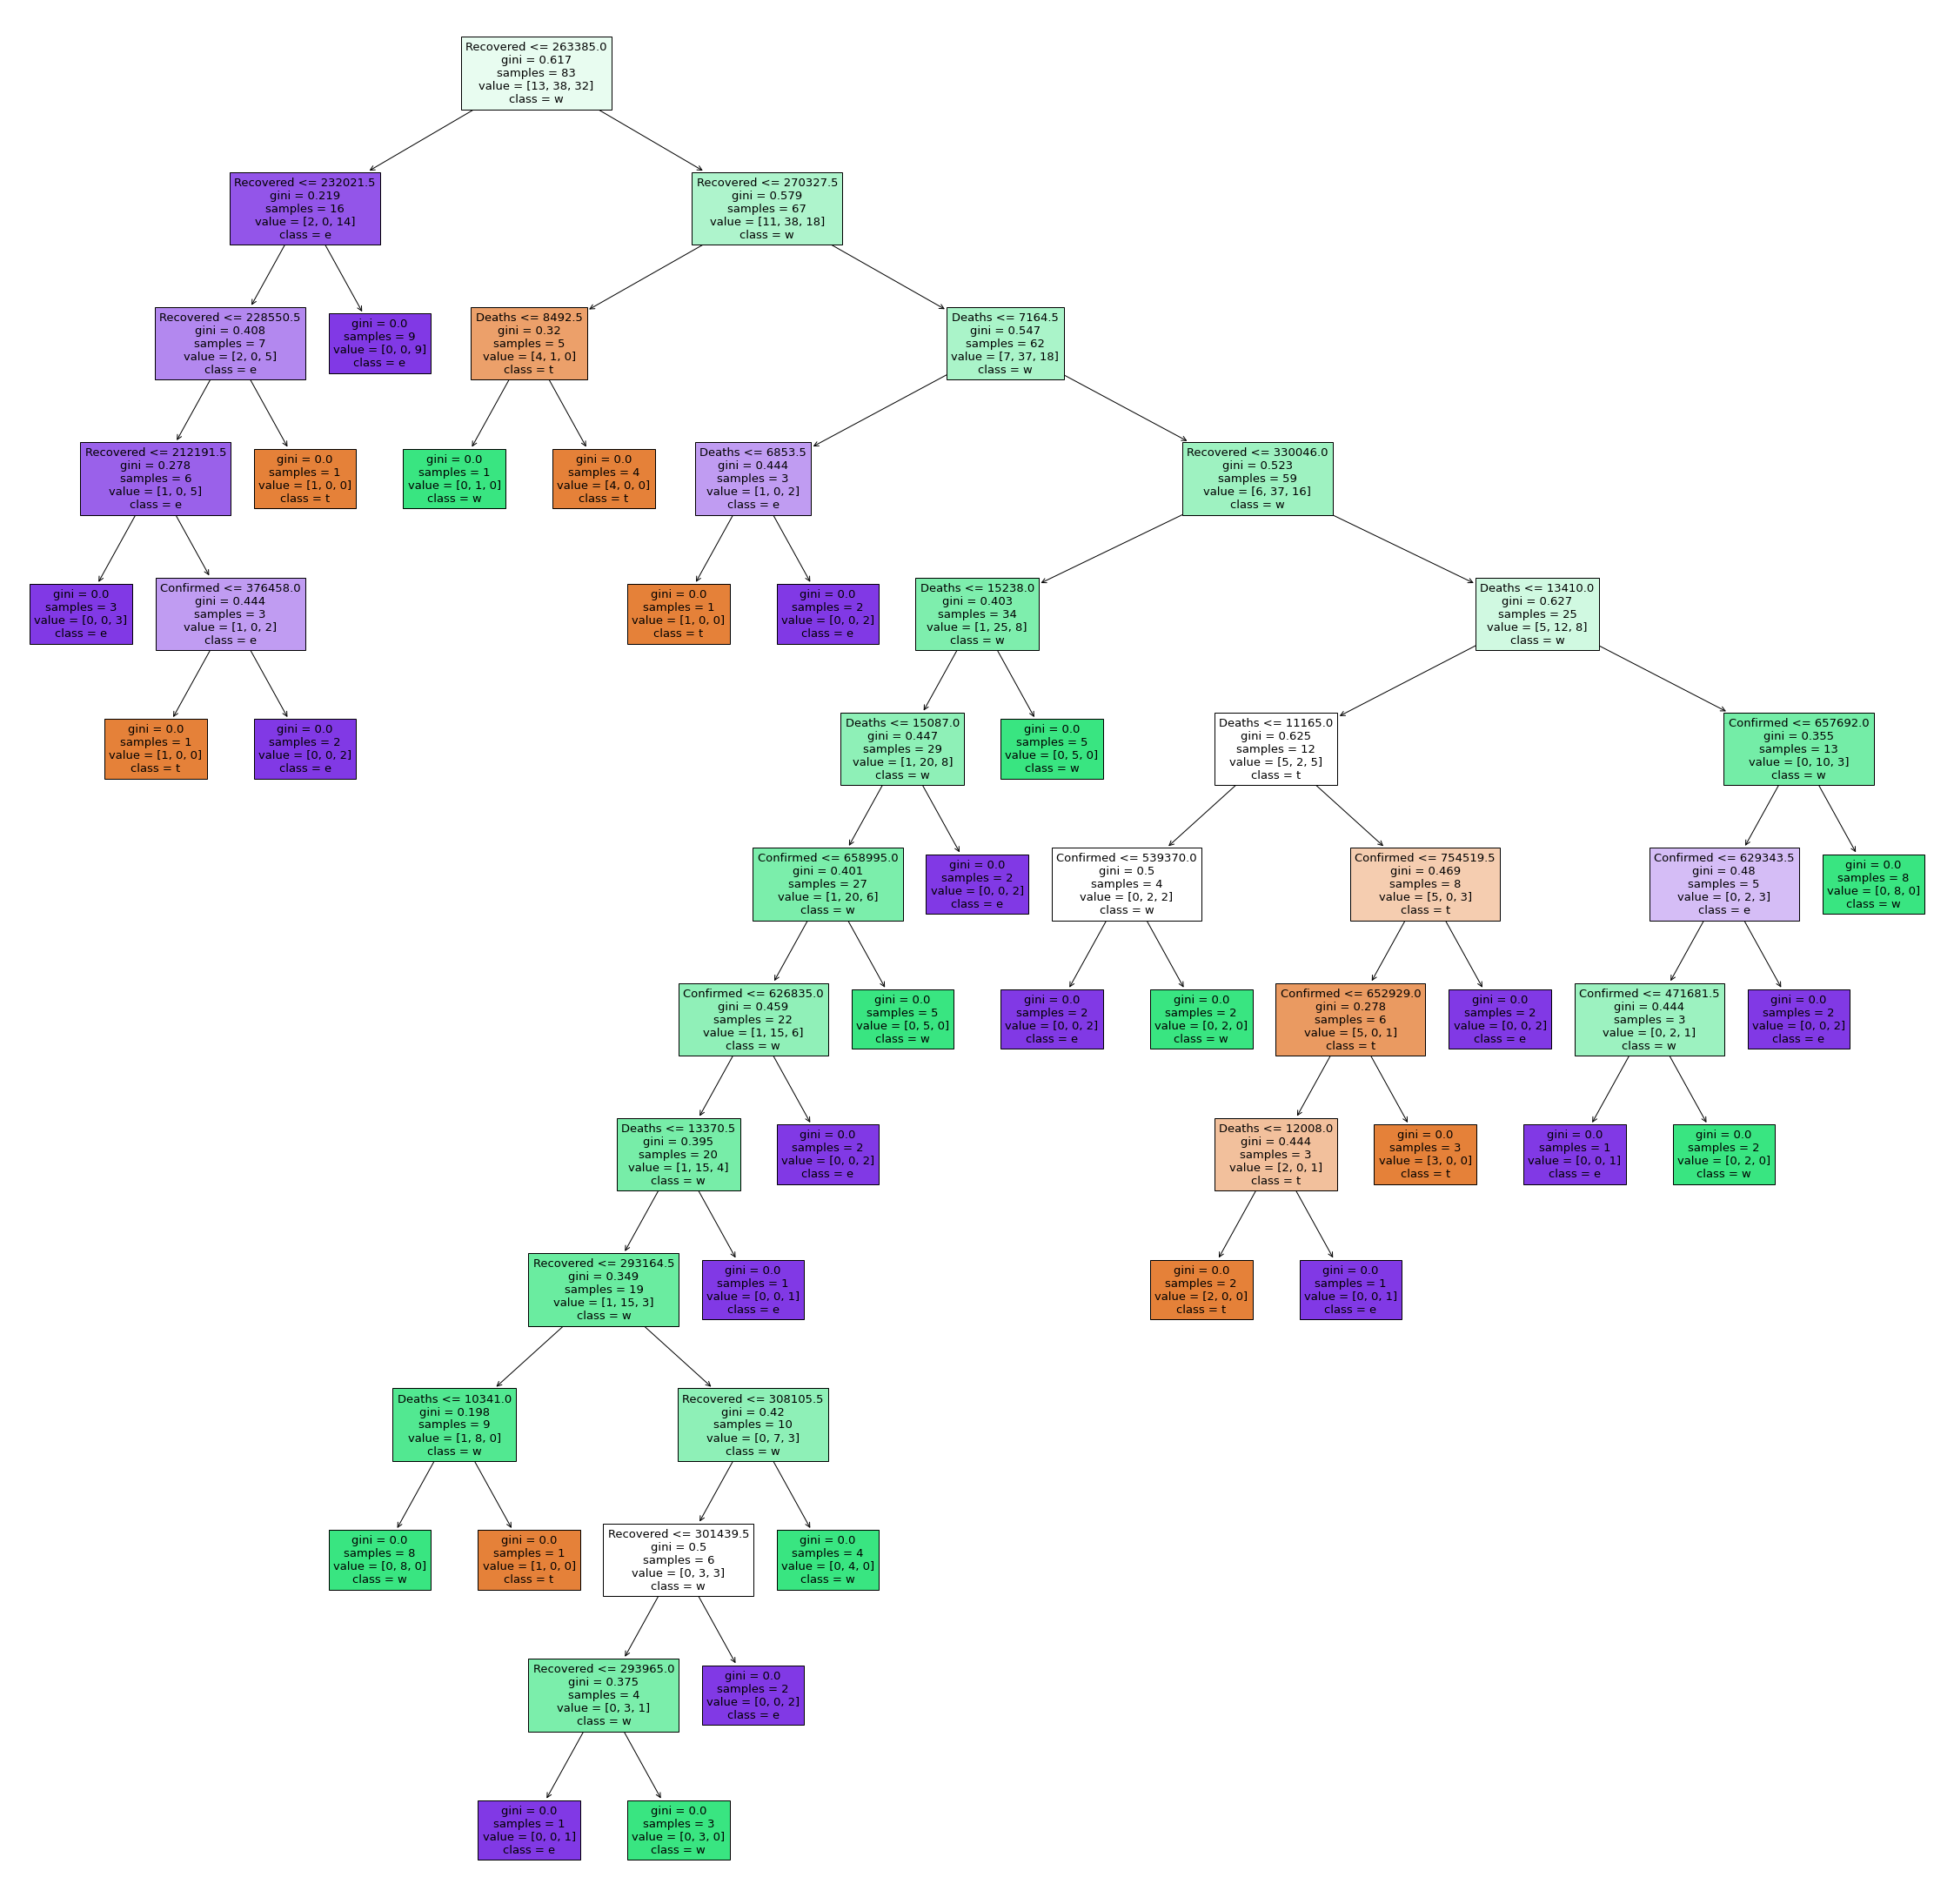

In [392]:
from sklearn import tree
fig = plt.figure(figsize=(40,40))
_ = tree.plot_tree(clf, 
                   feature_names=feature_cols,  
                   class_names='tweet_count',
                   filled=True)

<AxesSubplot:xlabel='Date'>

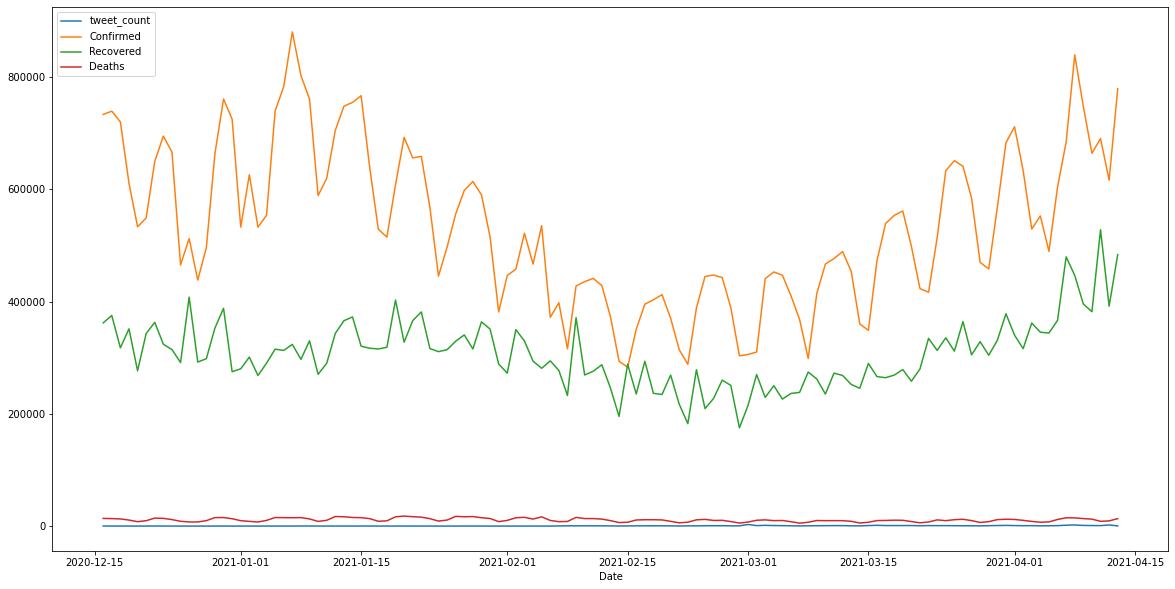

In [355]:
tweetsDay.plot(kind='line', x='Date', y=['tweet_count','Confirmed','Recovered','Deaths'], figsize=(20,10))
#tweetsDay.plot(kind='line', x='Date', , figsize=(20,6))

Text(0.5, 1.0, 'Tweets and Deaths')

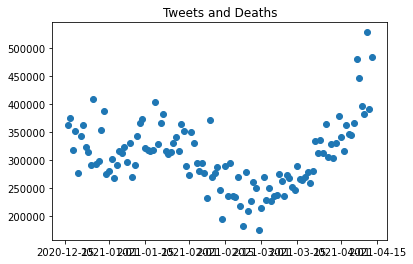

In [367]:
plt.scatter(tweetsDay.Date, tweetsDay.Recovered)
plt.title('Tweets and Deaths')

In [378]:
from sklearn import cluster 
td = np.array(td)
k = 4
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(td)

KMeans(n_clusters=4)

[[4.02000000e+02 6.05691097e+05 3.39137806e+05 1.20079355e+04]
 [4.90850000e+02 4.76661875e+05 2.86193725e+05 1.03114250e+04]
 [4.45173913e+02 7.45672435e+05 3.65532435e+05 1.41912174e+04]
 [5.52080000e+02 3.54130600e+05 2.49215880e+05 8.31480000e+03]]


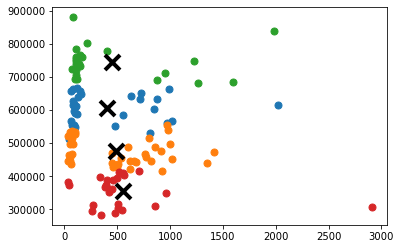

In [379]:
# labels are the cluster the point belongs to. 
labels = kmeans.labels_
# Centroids are the center of the cluster. 
centroids = kmeans.cluster_centers_
print(centroids)

for i in range(k):
    # select only data observations with cluster label == i
    ds = td[np.where(labels==i)]
    # plot the data observations
    plt.plot(ds[:,0],ds[:,1],'o', markersize=7)
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=15.0)
    plt.setp(lines,mew=4.0)
plt.show()